# Set up

In [1]:
!uv pip install -q langgraph langchain_core langgraph_supervisor
!uv pip install -q langsmith langchain-community sqlalchemy
!uv pip install -q openevals

In [2]:
!uv pip install -U langchain-google-genai
# did this to fix compatibility issues
!uv pip uninstall pydantic pydantic-core
!uv pip install pydantic==2.10.6 pydantic-core==2.27.2

Using Python 3.12.9 environment at: /opt/miniconda3
Resolved 39 packages in 981ms                                        
Prepared 2 packages in 1ms                                               
Uninstalled 2 packages in 25ms
Installed 2 packages in 9ms                                 
 - pydantic==2.10.6
 + pydantic==2.11.7
 - pydantic-core==2.27.2
 + pydantic-core==2.33.2
Using Python 3.12.9 environment at: /opt/miniconda3
Uninstalled 2 packages in 8ms
 - pydantic==2.11.7
 - pydantic-core==2.33.2
Using Python 3.12.9 environment at: /opt/miniconda3
Resolved 4 packages in 3ms                                           
Installed 2 packages in 2ms                                 
 + pydantic==2.10.6
 + pydantic-core==2.27.2


In [ ]:
import os
os.environ['LANGSMITH_API_KEY'] = "YOUR_API_KEY"
os.environ['GOOGLE_API_KEY'] = "YOUR_GOOGLE_API_KEY"
os.environ['LANGSMITH_TRACING'] = 'true'
# project name
os.environ['LANGSMITH_PROJECT'] = 'intelligent-rag-system'

In [4]:
from langsmith import utils
print(f'LangSmith tracing is enabled: {utils.tracing_is_enabled()}')

LangSmith tracing is enabled: True


# get database

In [5]:
import sqlite3
import requests
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

**Chinook digital music store Database**
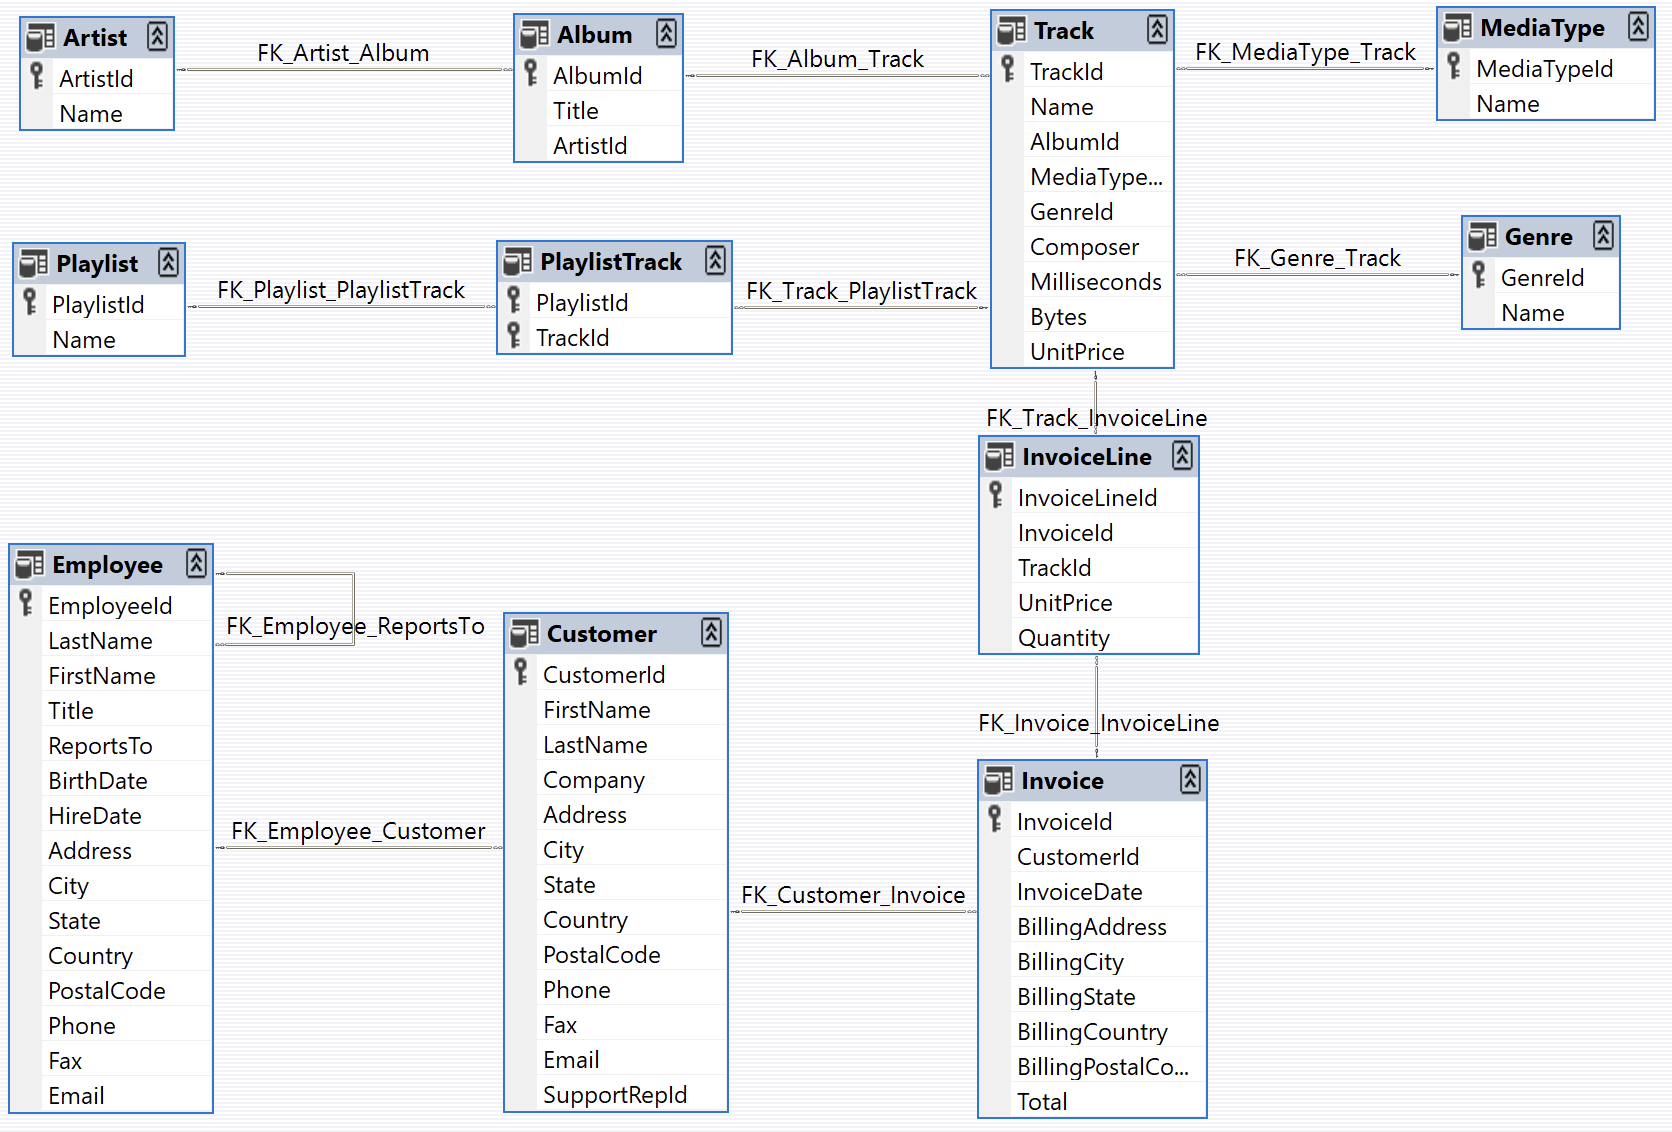

In [ ]:
def get_engine_for_chinook_db():
    # get the SQL script for the Chinook database
    url = "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql"
    response = requests.get(url)
    sql_script = response.text

    # create empty SQLite database
    connection = sqlite3.connect(":memory:", check_same_thread=False) # check_same_thread=False allows the connection to be used across threads
    
    # execute script to populate the database
    connection.executescript(sql_script)
    
    # set up engine for query 
    return create_engine(
        "sqlite://",  # SQLite url scheme
        creator=lambda: connection,  # function that returns the database connection
        poolclass=StaticPool,  # maintain single connection
        connect_args={"check_same_thread": False},  # allow cross-thread usage
    )

In [7]:
engine = get_engine_for_chinook_db()
db = SQLDatabase(engine)

# Full picture
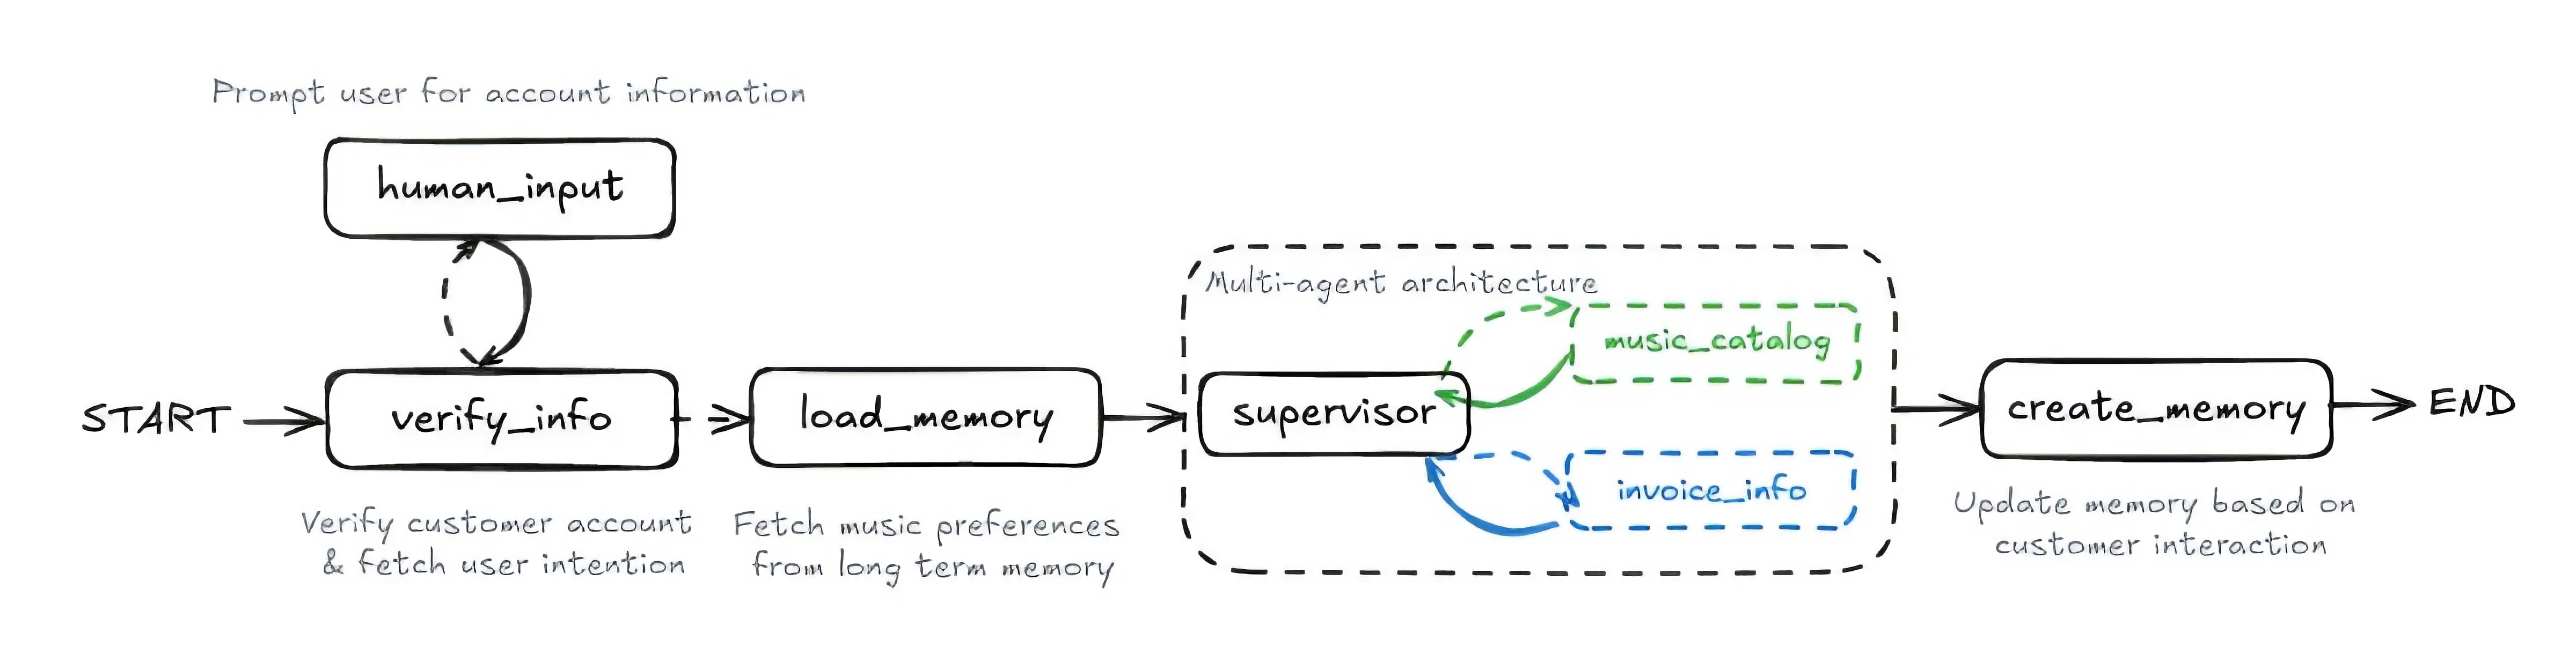

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite-preview-06-17", 
    temperature=0,      
    max_tokens=None,
    timeout=None,
    max_retries=5,
)

# Memory: agent with hippocampus unlike me

- MemorySaver = track current conversation context
- InMemoryStore = track cross-conversation; just a quick user preference storage -> in real production use permanent database

In [55]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore

checkpointer = MemorySaver()
in_memory_store = InMemoryStore()

# 1st agent to handle music info query

State

In [56]:
from typing_extensions import TypedDict # keep dict in same structure
from typing import Annotated, List

from langgraph.graph.message import AnyMessage, add_messages
from langgraph.managed.is_last_step import RemainingSteps

class State(TypedDict):
    customer_id: str
    # Conversation history with automatic message aggregation
    messages: Annotated[List[AnyMessage], add_messages]
    loaded_memory: str
    # counter to prevent infinite loops
    remaining_steps: RemainingSteps

Tools: access database

In [57]:
from langchain_core.tools import tool
import ast

@tool
def get_albums_by_artist(artist: str):
    """
    Get albums by an artist from the music database.
    
    Args:
        artist (str): The name of the artist to search for albums.
    
    Returns:
        str:
    """
    return db.run(
        f"""
        SELECT Album.Title, Artist.Name 
        FROM Album 
        JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

In [58]:
@tool
def get_tracks_by_artist(artist: str):
    """
    Get songs/tracks by an artist (or similar artists) from the music database.
    
    Args:
        artist (str): The name of the artist to search for tracks.
    
    Returns:
        str: Database query results containing song names and artist names.
    """
    return db.run(
        f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName 
        FROM Album 
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        LEFT JOIN Track ON Track.AlbumId = Album.AlbumId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

In [59]:
@tool
def get_songs_by_genre(genre: str):
    """
    Fetch songs from the database that match a specific genre.
    
    This function first looks up the genre ID(s) for the given genre name,
    then retrieves songs that belong to those genre(s), limiting results
    to 8 songs grouped by artist.
    
    Args:
        genre (str): The genre of the songs to fetch.
    
    Returns:
        list[dict] or str: A list of songs with artist information that match 
                          the specified genre, or an error message if no songs found.
    """
    # First, get the genre ID(s) for the specified genre
    genre_id_query = f"SELECT GenreId FROM Genre WHERE Name LIKE '%{genre}%'"
    genre_ids = db.run(genre_id_query)
    
    # Check if any genres were found
    if not genre_ids:
        return f"No songs found for the genre: {genre}"
    
    # Parse the genre IDs and format them for the SQL query
    genre_ids = ast.literal_eval(genre_ids)
    genre_id_list = ", ".join(str(gid[0]) for gid in genre_ids)

    # Query for songs in the specified genre(s)
    songs_query = f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName
        FROM Track
        LEFT JOIN Album ON Track.AlbumId = Album.AlbumId
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId
        WHERE Track.GenreId IN ({genre_id_list})
        GROUP BY Artist.Name
        LIMIT 8;
    """
    songs = db.run(songs_query, include_columns=True)
    
    # Check if any songs were found
    if not songs:
        return f"No songs found for the genre: {genre}"
    
    # Format the results into a structured list of dictionaries
    formatted_songs = ast.literal_eval(songs)
    return [
        {"Song": song["SongName"], "Artist": song["ArtistName"]}
        for song in formatted_songs
    ]

In [60]:
@tool
def check_for_songs(song_title):
    """
    Check if a song exists in the database by its name.
    
    Args:
        song_title (str): The title of the song to search for.
    
    Returns:
        str: Database query results containing all track information 
             for songs matching the given title.
    """
    return db.run(
        f"""
        SELECT * FROM Track WHERE Name LIKE '%{song_title}%';
        """,
        include_columns=True
    )

In [61]:
# Create a list of all music-related tools for the agent
music_tools = [get_albums_by_artist, get_tracks_by_artist, get_songs_by_genre, check_for_songs]

# Bind the music tools to the language model for use in the ReAct agent
llm_with_music_tools = llm.bind_tools(music_tools)

Node input(current_state) -> output(updated_state)
- music assistant: llm node
- tool_node: manage tool selected by music assistant

In [62]:
from langchain_core.messages import ToolMessage, HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

def generate_music_assistant_prompt(memory: str = "None") -> str:
    return f"""
    You are a member of the assistant team, your role specifically is to focused on helping customers discover and learn about music in our digital catalog. 
    If you are unable to find playlists, songs, or albums associated with an artist, it is okay. 
    Just inform the customer that the catalog does not have any playlists, songs, or albums associated with that artist.
    You also have context on any saved user preferences, helping you to tailor your response. 
    
    CORE RESPONSIBILITIES:
    - Search and provide accurate information about songs, albums, artists, and playlists
    - Offer relevant recommendations based on customer interests
    - Handle music-related queries with attention to detail
    - Help customers discover new music they might enjoy
    - You are routed only when there are questions related to music catalog; ignore other questions. 
    
    SEARCH GUIDELINES:
    1. Always perform thorough searches before concluding something is unavailable
    2. If exact matches aren't found, try:
       - Checking for alternative spellings
       - Looking for similar artist names
       - Searching by partial matches
       - Checking different versions/remixes
    3. When providing song lists:
       - Include the artist name with each song
       - Mention the album when relevant
       - Note if it's part of any playlists
       - Indicate if there are multiple versions
    
    Additional context is provided below: 

    Prior saved user preferences: {memory}
    
    Message history is also attached.  
    """

In [ ]:
# music_assistant node
def music_assistant(state: State, config: RunnableConfig):
    # retrieve long-term memory if available
    memory = "None"
    if "loaded_memory" in state:
        memory = state['loaded_memory']

    music_assistant_prompt = generate_music_assistant_prompt(memory)

    response = llm_with_music_tools.invoke(
        [SystemMessage(music_assistant_prompt)] \
            + state['messages'])
    return {'messages': [response]}

In [64]:
from langgraph.prebuilt import ToolNode
music_tools_node = ToolNode(music_tools)

Conditional Edges: examine current state and decide which node to visit next.

In [ ]:
def should_continue(state: State, config: RunnableConfig):
    # get all message in current state
    messages = state["messages"]
    # if no tool calls, end the conversation
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

AVENGERS ASSEMBLE!

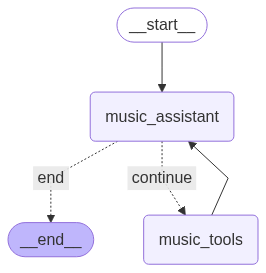

In [ ]:
from langgraph.graph import StateGraph, START, END

# instantiate the graph
music_workflow = StateGraph(State)

music_workflow.add_node("music_assistant", music_assistant)
music_workflow.add_node("music_tools", music_tools_node)

music_workflow.add_edge(START, "music_assistant")
music_workflow.add_conditional_edges(
    'music_assistant',
    should_continue,
    {
        'continue': 'music_tools',
        'end': END
    },
)

music_workflow.add_edge("music_tools", "music_assistant")

# compile with 'checkpointer' for short-term memory and 'store' for long-term memory
music_catalog_subagent = music_workflow.compile(
    name="music_catalog_subagent", 
    checkpointer=checkpointer, 
    store=in_memory_store
)

# Display the compiled graph structure
from IPython.display import Image, display
display(Image(music_catalog_subagent.get_graph().draw_mermaid_png()))

In [21]:
import uuid
from langchain_core.messages import HumanMessage

# Generate a unique thread ID for this conversation session
thread_id = uuid.uuid4()

config={"configurable": {"thread_id": thread_id}}
result = music_catalog_subagent.invoke({"messages": [HumanMessage("Hi")]}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello! How can I help you discover some music today?


# 2nd agent: Invoice Information agent Using Pre-built

- get_invoices_by_customer_sorted_by_date: Retrieves all invoices for a customer, sorted by date
- get_invoices_sorted_by_unit_price: Retrieves invoices sorted by the unit price of items within them
- get_employee_by_invoice_and_customer: Finds the support employee associated with a specific invoice

In [67]:
from langchain_core.tools import tool

@tool 
def get_invoices_by_customer_sorted_by_date(customer_id: str) -> list[dict]:
    """
    Look up all invoices for a customer using their ID.
    The invoices are sorted in descending order by invoice date, which helps when the customer wants to view their most recent/oldest invoice, or if 
    they want to view invoices within a specific date range.
    
    Args:
        customer_id (str): customer_id, which serves as the identifier.
    
    Returns:
        list[dict]: A list of invoices for the customer.
    """
    return db.run(f"SELECT * FROM Invoice WHERE CustomerId = {customer_id} ORDER BY InvoiceDate DESC;")


@tool 
def get_invoices_sorted_by_unit_price(customer_id: str) -> list[dict]:
    """
    Use this tool when the customer wants to know the details of one of their invoices based on the unit price/cost of the invoice.
    This tool looks up all invoices for a customer, and sorts the unit price from highest to lowest. In order to find the invoice associated with the customer, 
    we need to know the customer ID.
    
    Args:
        customer_id (str): customer_id, which serves as the identifier.
    
    Returns:
        list[dict]: A list of invoices sorted by unit price.
    """
    query = f"""
        SELECT Invoice.*, InvoiceLine.UnitPrice
        FROM Invoice
        JOIN InvoiceLine ON Invoice.InvoiceId = InvoiceLine.InvoiceId
        WHERE Invoice.CustomerId = {customer_id}
        ORDER BY InvoiceLine.UnitPrice DESC;
    """
    return db.run(query)


@tool
def get_employee_by_invoice_and_customer(invoice_id: str, customer_id: str) -> dict:
    """
    This tool will take in an invoice ID and a customer ID and return the employee information associated with the invoice.

    Args:
        invoice_id (int): The ID of the specific invoice.
        customer_id (str): customer_id, which serves as the identifier.

    Returns:
        dict: Information about the employee associated with the invoice.
    """

    query = f"""
        SELECT Employee.FirstName, Employee.Title, Employee.Email
        FROM Employee
        JOIN Customer ON Customer.SupportRepId = Employee.EmployeeId
        JOIN Invoice ON Invoice.CustomerId = Customer.CustomerId
        WHERE Invoice.InvoiceId = ({invoice_id}) AND Invoice.CustomerId = ({customer_id});
    """
    
    employee_info = db.run(query, include_columns=True)
    
    if not employee_info:
        return f"No employee found for invoice ID {invoice_id} and customer identifier {customer_id}."
    return employee_info

In [ ]:
invoice_tools = [get_invoices_by_customer_sorted_by_date, get_invoices_sorted_by_unit_price, get_employee_by_invoice_and_customer]

In [69]:
invoice_subagent_prompt = """
    You are a subagent among a team of assistants. You are specialized for retrieving and processing invoice information. You are routed for invoice-related portion of the questions, so only respond to them.. 

    You have access to three tools. These tools enable you to retrieve and process invoice information from the database. Here are the tools:
    - get_invoices_by_customer_sorted_by_date: This tool retrieves all invoices for a customer, sorted by invoice date.
    - get_invoices_sorted_by_unit_price: This tool retrieves all invoices for a customer, sorted by unit price.
    - get_employee_by_invoice_and_customer: This tool retrieves the employee information associated with an invoice and a customer.
    
    If you are unable to retrieve the invoice information, inform the customer you are unable to retrieve the information, and ask if they would like to search for something else.
    
    CORE RESPONSIBILITIES:
    - Retrieve and process invoice information from the database
    - Provide detailed information about invoices, including customer details, invoice dates, total amounts, employees associated with the invoice, etc. when the customer asks for it.
    - Always maintain a professional, friendly, and patient demeanor
    
    You may have additional context that you should use to help answer the customer's query. It will be provided to you below:
    """

In [ ]:
from langgraph.prebuilt import create_react_agent

invoice_information_subagent = create_react_agent(
    llm,                         
    tools=invoice_tools,           
    name="invoice_information_subagent", 
    prompt=invoice_subagent_prompt,    
    state_schema=State,          
    checkpointer=checkpointer, 
    store=in_memory_store
)

In [ ]:
# generate unique thread ID for this conversation session
thread_id = uuid.uuid4()

question = "My customer id is 1. What was my most recent invoice, and who was the employee that helped me with it?"
config = {"configurable": {"thread_id": thread_id}}

result = invoice_information_subagent.invoke({"messages": [HumanMessage(content=question)]}, config=config)

# display all messages
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

My customer id is 1. What was my most recent invoice, and who was the employee that helped me with it?
================================== Ai Message ==================================
Name: invoice_information_subagent
Tool Calls:
  get_invoices_by_customer_sorted_by_date (39dcae0a-678b-4bfd-944b-c4796a091fe5)
 Call ID: 39dcae0a-678b-4bfd-944b-c4796a091fe5
  Args:
    customer_id: 1
================================= Tool Message =================================
Name: get_invoices_by_customer_sorted_by_date

[(382, 1, '2025-08-07 00:00:00', 'Av. Brigadeiro Faria Lima, 2170', 'São José dos Campos', 'SP', 'Brazil', '12227-000', 8.91), (327, 1, '2024-12-07 00:00:00', 'Av. Brigadeiro Faria Lima, 2170', 'São José dos Campos', 'SP', 'Brazil', '12227-000', 13.86), (316, 1, '2024-10-27 00:00:00', 'Av. Brigadeiro Faria Lima, 2170', 'São José dos Campos', 'SP', 'Brazil', '12227-000', 1.98), (195, 1, '2023-05-06 00:

# Supervisor

In [71]:
supervisor_prompt = """You are an expert customer support assistant for a digital music store. 
You are dedicated to providing exceptional service and ensuring customer queries are answered thoroughly. 
You have a team of subagents that you can use to help answer queries from customers. 
Your primary role is to serve as a supervisor/planner for this multi-agent team that helps answer queries from customers. 

Your team is composed of two subagents that you can use to help answer the customer's request:
1. music_catalog_information_subagent: this subagent has access to user's saved music preferences. It can also retrieve information about the digital music store's music 
catalog (albums, tracks, songs, etc.) from the database. 
3. invoice_information_subagent: this subagent is able to retrieve information about a customer's past purchases or invoices 
from the database. 

Based on the existing steps that have been taken in the messages, your role is to generate the next subagent that needs to be called. 
This could be one step in an inquiry that needs multiple sub-agent calls. """

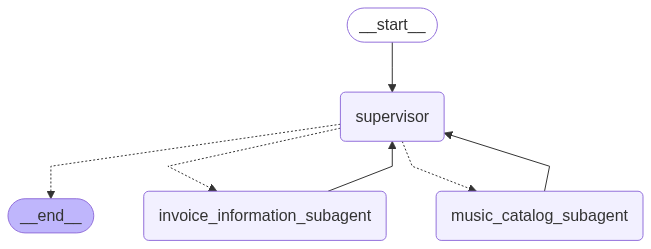

In [ ]:
from langgraph_supervisor import create_supervisor

# pre-built supervisor
supervisor_prebuilt_workflow = create_supervisor(
    agents=[invoice_information_subagent, music_catalog_subagent], 
    output_mode="last_message",  # Return only the final response (alternative: "full_history")
    model=llm, 
    prompt=(supervisor_prompt), 
    state_schema=State  # State schema defining data flow structure
)


supervisor_prebuilt = supervisor_prebuilt_workflow.compile(
    name="music_catalog_subagent", 
    checkpointer=checkpointer, 
    store=in_memory_store
)

# display the compiled graph structure
from IPython.display import Image, display
display(Image(supervisor_prebuilt.get_graph().draw_mermaid_png()))

In [ ]:
# generate unique thread ID for this conversation session
thread_id = uuid.uuid4()

question = "My customer ID is 1. How much was my most recent purchase? What albums do you have by U2?"
config = {"configurable": {"thread_id": thread_id}}

result = supervisor_prebuilt.invoke({"messages": [HumanMessage(content=question)]}, config=config)

# display all messages
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

My customer ID is 1. How much was my most recent purchase? What albums do you have by U2?
================================== Ai Message ==================================
Name: supervisor

Okay, I need to find out the customer's most recent purchase and also get information about U2 albums. I will call the invoice_information_subagent first to find the most recent purchase, and then I will call the music_catalog_subagent to find the U2 albums.
Tool Calls:
  transfer_to_invoice_information_subagent (45819f7e-5e41-4a1a-9b98-fbb5a27ccd35)
 Call ID: 45819f7e-5e41-4a1a-9b98-fbb5a27ccd35
  Args:
================================= Tool Message =================================
Name: transfer_to_invoice_information_subagent

Successfully transferred to invoice_information_subagent
================================== Ai Message ==================================
Name: invoice_information_subagent

I can help you wit

# Human-in-the-Loop user verification

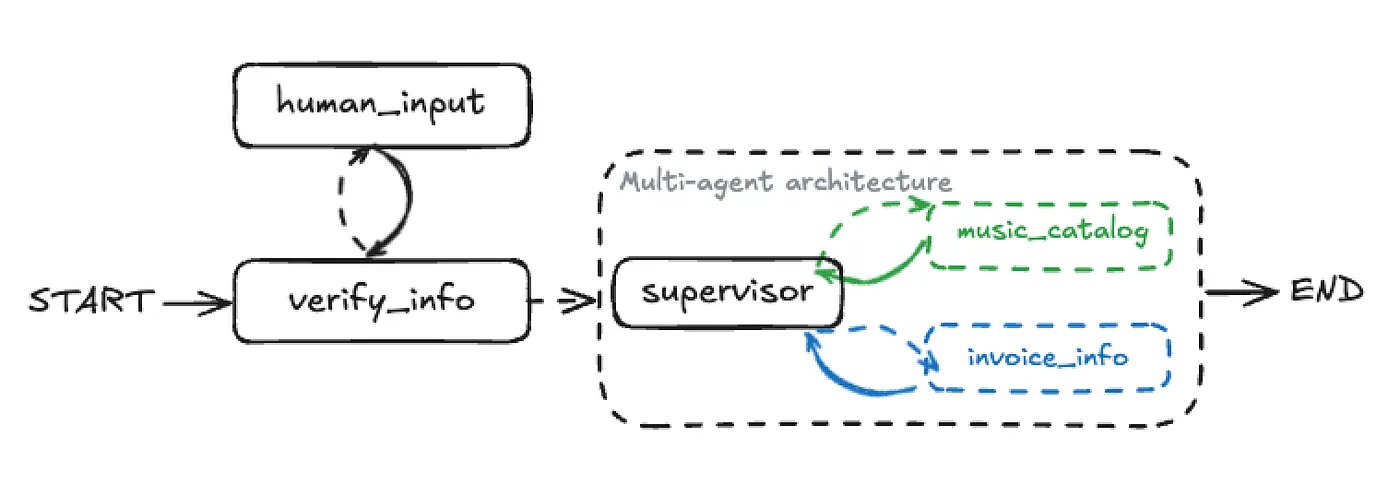

interupt() -> take user input -> resume

https://python.langchain.com/docs/concepts/structured_outputs/

In [ ]:
from pydantic import BaseModel, Field

class UserInput(BaseModel):
    # schema for parsing user-provided account information.
    identifier: str = Field(description="Identifier, which can be a customer ID, email, or phone number.")
structured_llm = llm.with_structured_output(schema=UserInput)

# system prompt for extracting customer identifier information
structured_system_prompt = """You are a customer service representative responsible for extracting customer identifier.
Only extract the customer's account information from the message history. 
If they haven't provided the information yet, return an empty string for the identifier."""

In [74]:
from typing import Optional 

# Helper function for customer identification
def get_customer_id_from_identifier(identifier: str) -> Optional[int]:
    """
    Retrieve Customer ID using an identifier, which can be a customer ID, email, or phone number.
    
    This function supports three types of identifiers:
    1. Direct customer ID (numeric string)
    2. Phone number (starts with '+')
    3. Email address (contains '@')
    
    Args:
        identifier (str): The identifier can be customer ID, email, or phone number.
    
    Returns:
        Optional[int]: The CustomerId if found, otherwise None.
    """
    # Check if identifier is a direct customer ID (numeric)
    if identifier.isdigit():
        return int(identifier)
    
    # Check if identifier is a phone number (starts with '+')
    elif identifier[0] == "+":
        query = f"SELECT CustomerId FROM Customer WHERE Phone = '{identifier}';"
        result = db.run(query)
        formatted_result = ast.literal_eval(result)
        if formatted_result:
            return formatted_result[0][0]
    
    # Check if identifier is an email address (contains '@')
    elif "@" in identifier:
        query = f"SELECT CustomerId FROM Customer WHERE Email = '{identifier}';"
        result = db.run(query)
        formatted_result = ast.literal_eval(result)
        if formatted_result:
            return formatted_result[0][0]
    
    # Return None if no match found
    return None 

In [75]:
def verify_info(state: State, config: RunnableConfig):
    """
    Verify the customer's account by parsing their input and matching it with the database.
    
    This node handles customer identity verification as the first step in the support process.
    It extracts customer identifiers (ID, email, or phone) from user messages and validates
    them against the database.
    
    Args:
        state (State): Current state containing messages and potentially customer_id
        config (RunnableConfig): Configuration for the runnable execution
        
    Returns:
        dict: Updated state with customer_id if verified, or request for more info
    """
    # Only verify if customer_id is not already set
    if state.get("customer_id") is None: 
        # System instructions for prompting customer verification
        system_instructions = """You are a music store agent, where you are trying to verify the customer identity 
        as the first step of the customer support process. 
        Only after their account is verified, you would be able to support them on resolving the issue. 
        In order to verify their identity, one of their customer ID, email, or phone number needs to be provided.
        If the customer has not provided their identifier, please ask them for it.
        If they have provided the identifier but cannot be found, please ask them to revise it."""

        # Get the most recent user message
        user_input = state["messages"][-1] 
    
        # Use structured LLM to parse customer identifier from the message
        parsed_info = structured_llm.invoke([SystemMessage(content=structured_system_prompt)] + [user_input])
    
        # Extract the identifier from parsed response
        identifier = parsed_info.identifier
    
        # Initialize customer_id as empty
        customer_id = ""
        
        # Attempt to find the customer ID using the provided identifier
        if (identifier):
            customer_id = get_customer_id_from_identifier(identifier)
    
        # If customer found, confirm verification and set customer_id in state
        if customer_id != "":
            intent_message = SystemMessage(
                content= f"Thank you for providing your information! I was able to verify your account with customer id {customer_id}."
            )
            return {
                  "customer_id": customer_id,
                  "messages" : [intent_message]
                  }
        else:
            # If customer not found, ask for correct information
            response = llm.invoke([SystemMessage(content=system_instructions)]+state['messages'])
            return {"messages": [response]}

    else: 
        # Customer already verified, no action needed
        pass

In [76]:
from langgraph.types import interrupt

def human_input(state: State, config: RunnableConfig):
    """
    Human-in-the-loop node that interrupts the workflow to request user input.
    
    This node creates an interruption point in the workflow, allowing the system
    to pause and wait for human input before continuing. It's typically used
    for customer verification or when additional information is needed.
    
    Args:
        state (State): Current state containing messages and workflow data
        config (RunnableConfig): Configuration for the runnable execution
        
    Returns:
        dict: Updated state with the user's input message
    """
    # Interrupt the workflow and prompt for user input
    user_input = interrupt("Please provide input.")
    
    # Return the user input as a new message in the state
    return {"messages": [user_input]}

In [77]:
# Conditional edge: should_interrupt
def should_interrupt(state: State, config: RunnableConfig):
    """
    Determines whether the workflow should interrupt and ask for human input.
    
    If the customer_id is present in the state (meaning verification is complete),
    the workflow continues. Otherwise, it interrupts to get human input for verification.
    """
    if state.get("customer_id") is not None:
        return "continue" # Customer ID is verified, continue to the next step (supervisor)
    else:
        return "interrupt" # Customer ID is not verified, interrupt for human input

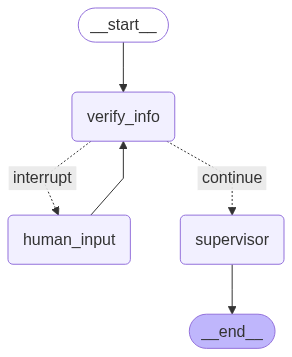

In [78]:
# Create a new StateGraph instance for the multi-agent workflow with verification
multi_agent_verify = StateGraph(State)

# Add new nodes for customer verification and human interaction
multi_agent_verify.add_node("verify_info", verify_info)
multi_agent_verify.add_node("human_input", human_input)
# Add the existing supervisor agent as a node
multi_agent_verify.add_node("supervisor", supervisor_prebuilt)

# Define the graph's entry point: always start with information verification
multi_agent_verify.add_edge(START, "verify_info")

# Add a conditional edge from verify_info to decide whether to continue or interrupt
multi_agent_verify.add_conditional_edges(
    "verify_info",
    should_interrupt, # The function that checks if customer_id is verified
    {
        "continue": "supervisor", # If verified, proceed to the supervisor
        "interrupt": "human_input", # If not verified, interrupt for human input
    },
)
# After human input, always loop back to verify_info to re-attempt verification
multi_agent_verify.add_edge("human_input", "verify_info")
# After the supervisor completes its task, the workflow ends
multi_agent_verify.add_edge("supervisor", END)

# Compile the complete graph with checkpointer and long-term memory store
multi_agent_verify_graph = multi_agent_verify.compile(
    name="multi_agent_verify", 
    checkpointer=checkpointer, 
    store=in_memory_store
)

# Display the compiled graph structure
from IPython.display import Image, display
display(Image(multi_agent_verify_graph.get_graph().draw_mermaid_png()))

In [36]:
thread_id = uuid.uuid4()
question = "How much was my most recent purchase?"
config = {"configurable": {"thread_id": thread_id}}

result = multi_agent_verify_graph.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

How much was my most recent purchase?
================================== Ai Message ==================================

I am sorry, I am unable to look up your purchase history without verifying your identity first. Could you please provide either your customer ID, email, or phone number associated with your account?


In [37]:
from langgraph.types import Command

# Resume from the interrupt, providing the phone number for verification
question = "My phone number is +55 (12) 3923-5555."
result = multi_agent_verify_graph.invoke(Command(resume=question), config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

How much was my most recent purchase?
================================== Ai Message ==================================

I am sorry, I am unable to look up your purchase history without verifying your identity first. Could you please provide either your customer ID, email, or phone number associated with your account?
================================ Human Message =================================

My phone number is +55 (12) 3923-5555.
================================ System Message ================================

Thank you for providing your information! I was able to verify your account with customer id 1.
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_invoice_information_subagent (a5b4313f-b702-49e0-bd6a-e17e37a771bd)
 Call ID: a5b4313f-b702-49e0-bd6a-e17e37a771bd
  Args:
================================= Tool Message ======

In [38]:
# if continue asking in the same thread, no verification needed
question = "What albums do you have by the Rolling Stones?"
result = multi_agent_verify_graph.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

How much was my most recent purchase?
================================== Ai Message ==================================

I am sorry, I am unable to look up your purchase history without verifying your identity first. Could you please provide either your customer ID, email, or phone number associated with your account?
================================ Human Message =================================

My phone number is +55 (12) 3923-5555.
================================ System Message ================================

Thank you for providing your information! I was able to verify your account with customer id 1.
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_invoice_information_subagent (a5b4313f-b702-49e0-bd6a-e17e37a771bd)
 Call ID: a5b4313f-b702-49e0-bd6a-e17e37a771bd
  Args:
================================= Tool Message ======

# add long term memore

In [ ]:
from langgraph.store.base import BaseStore

# Helper function to format user memory data for LLM prompts
def format_user_memory(user_data):
    """Formats music preferences from users, if available."""
    profile = user_data['memory'] 
    result = ""
    
    if hasattr(profile, 'music_preferences') and profile.music_preferences:
        result += f"Music Preferences: {', '.join(profile.music_preferences)}"
    return result.strip()

# Node: load_memory
def load_memory(state: State, config: RunnableConfig, store: BaseStore):
    """
    Loads music preferences from the long-term memory store for a given user.
    
    This node fetches previously saved user preferences to provide context
    for the current conversation, enabling personalized responses.
    """
    # Get the user_id from the configurable part of the config
    # In our evaluation setup, we might pass user_id via config
    user_id = config["configurable"].get("user_id", state["customer_id"]) # Use customer_id if user_id not in config
    
    # Define the namespace and key for accessing memory in the store
    namespace = ("memory_profile", user_id)
    key = "user_memory"
    
    # Retrieve existing memory for the user
    existing_memory = store.get(namespace, key)
    formatted_memory = ""
    
    # Format the retrieved memory if it exists and has content
    if existing_memory and existing_memory.value:
        formatted_memory = format_user_memory(existing_memory.value)

    # Update the state with the loaded and formatted memory
    return {"loaded_memory": formatted_memory}

In [80]:
class UserProfile(BaseModel):
    customer_id: str = Field(description="The customer ID of the customer")
    music_preferences: List[str] = Field(description="The music preferences of the customer")

In [ ]:
create_memory_prompt = """You are an expert analyst that is observing a conversation that has taken place between a customer and a customer support assistant. The customer support assistant works for a digital music store, and has utilized a multi-agent team to answer the customer's request. 
You are tasked with analyzing the conversation that has taken place between the customer and the customer support assistant, and updating the memory profile associated with the customer. The memory profile may be empty. If it's empty, you should create a new memory profile for the customer.

You specifically care about saving any music interest the customer has shared about themselves, particularly their music preferences to their memory profile.

To help you with this task, I have attached the conversation that has taken place between the customer and the customer support assistant below, as well as the existing memory profile associated with the customer that you should either update or create. 

The customer's memory profile should have the following fields:
- customer_id: the customer ID of the customer
- music_preferences: the music preferences of the customer

These are the fields you should keep track of and update in the memory profile. If there has been no new information shared by the customer, you should not update the memory profile. It is completely okay if you do not have new information to update the memory profile with. In that case, just leave the values as they are.

*IMPORTANT INFORMATION BELOW*

The existing memory profile associated with the customer that you should either update or create based on the conversation is as follows:
{memory_profile}

Ensure your response is an object that has the following fields:
- customer_id: the customer ID of the customer
- music_preferences: the music preferences of the customer

Think carefully before responding.
For each key in the object, if there is no new information, do not update the value, just keep the value that is already there. If there is new information, update the value. 
"""

In [ ]:
# Node: create_memory
def create_memory(state: State, config: RunnableConfig, store: BaseStore):
    """
    Analyzes conversation history and updates the user's long-term memory profile.
    
    This node extracts new music preferences shared by the customer during the
    conversation and persists them in the InMemoryStore for future interactions.
    """
    # Get the user_id from the configurable part of the config or from the state
    user_id = str(config["configurable"].get("user_id", state["customer_id"]))
    
    # Define the namespace and key for the memory profile
    namespace = ("memory_profile", user_id)
    key = "user_memory"
    
    # Retrieve the existing memory profile for the user
    existing_memory = store.get(namespace, key)
    
    # Format the existing memory for the LLM prompt
    formatted_memory = ""
    if existing_memory and existing_memory.value:
        existing_memory_dict = existing_memory.value
        # Ensure 'music_preferences' is treated as a list, even if it might be missing or None
        music_prefs = existing_memory_dict.get('music_preferences', [])
        if music_prefs:
            formatted_memory = f"Music Preferences: {', '.join(music_prefs)}"

    # Pass the system instructions and the conversation history as separate messages
    messages_to_send = [SystemMessage(content=create_memory_prompt.format(memory_profile=formatted_memory))] + state["messages"]

    # Invoke the LLM with the UserProfile schema to get structured updated memory
    updated_memory = llm.with_structured_output(UserProfile).invoke(messages_to_send)
    
    # Store the updated memory profile
    store.put(namespace, key, {"memory": updated_memory})

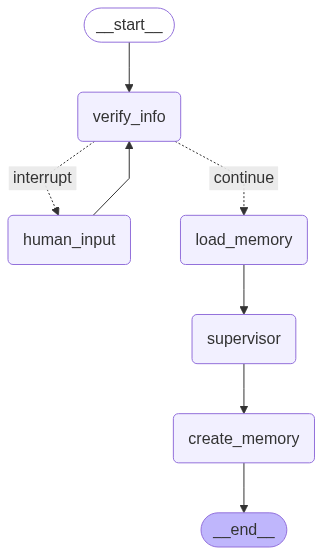

In [ ]:
multi_agent_final = StateGraph(State)

# Add all existing and new nodes to the graph
multi_agent_final.add_node("verify_info", verify_info)
multi_agent_final.add_node("human_input", human_input)
multi_agent_final.add_node("load_memory", load_memory)
multi_agent_final.add_node("supervisor", supervisor_prebuilt) # Our supervisor agent
multi_agent_final.add_node("create_memory", create_memory)

# Entry point
multi_agent_final.add_edge(START, "verify_info")

# Conditional routing after verification: interrupt if needed, else load memory
multi_agent_final.add_conditional_edges(
    "verify_info",
    should_interrupt, # Checks if customer_id is verified
    {
        "continue": "load_memory", # If verified, proceed to load long-term memory
        "interrupt": "human_input", # If not verified, interrupt for human input
    },
)

multi_agent_final.add_edge("human_input", "verify_info")
multi_agent_final.add_edge("load_memory", "supervisor")
multi_agent_final.add_edge("supervisor", "create_memory")
# End point
multi_agent_final.add_edge("create_memory", END)

# compile all
multi_agent_final_graph = multi_agent_final.compile(
    name="multi_agent_verify", 
    checkpointer=checkpointer, 
    store=in_memory_store
)

# display the final compiled graph structure
from IPython.display import Image, display
display(Image(multi_agent_final_graph.get_graph().draw_mermaid_png()))

In [46]:
thread_id = uuid.uuid4()

question = "My phone number is +55 (12) 3923-5555. How much was my most recent purchase? What albums do you have by the Rolling Stones?"
config = {"configurable": {"thread_id": thread_id}}

result = multi_agent_final_graph.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

My phone number is +55 (12) 3923-5555. How much was my most recent purchase? What albums do you have by the Rolling Stones?
================================ System Message ================================

Thank you for providing your information! I was able to verify your account with customer id 1.
================================== Ai Message ==================================
Name: supervisor

Okay, I can help with that. First, I need to find out about your most recent purchase. Then, I can look up albums by the Rolling Stones.

I will call the `invoice_information_subagent` first to find out about your most recent purchase.
Tool Calls:
  transfer_to_invoice_information_subagent (03e5c9bb-f0e4-4269-b4e0-6942b420cb9e)
 Call ID: 03e5c9bb-f0e4-4269-b4e0-6942b420cb9e
  Args:
================================= Tool Message =================================
Name: transfer_to_invoice_information_subagent

Suc

In [ ]:
# Check if the user's music preference was saved
user_id = "1" 
namespace = ("memory_profile", user_id)
memory = in_memory_store.get(namespace, "user_memory")

# Access the UserProfile object stored under the "memory" key
saved_music_preferences = memory.value.get("memory").music_preferences

print(saved_music_preferences)

# Evaluation

In [86]:
from langsmith import Client

client = Client()

test_set = [
    {
        "question": "My name is Aaron Mitchell. My number associated with my account is +1 (204) 452-6452. I am trying to find the invoice number for my most recent song purchase. Could you help me with it?",
        "response": "The Invoice ID of your most recent purchase was 342.",
    },
    {
        "question": "I'd like a refund.",
        "response": "I need additional information to help you with the refund. Could you please provide your customer identifier so that we can fetch your purchase history?",
    },
    {
        "question": "Who recorded Wish You Were Here again?",
        "response": "Wish You Were Here is an album by Pink Floyd",
    },
    { 
        "question": "What albums do you have by Coldplay?",
        "response": "There are no Coldplay albums available in our catalog at the moment.",
    },
]

dataset_name = "test_set"

# Check if the dataset already exists to avoid recreation errors
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    client.create_examples(
        inputs=[{"question": test["question"]} for test in test_set],
        outputs=[{"response": test["response"]} for test in test_set],
        dataset_id=dataset.id
    )

In [87]:
import uuid
from langgraph.types import Command

graph = multi_agent_final_graph

async def run_graph(inputs: dict):
    """
    Run the multi-agent graph workflow and return the final response.
    
    This function handles the complete workflow including:
    1. Initial invocation with user question
    2. Handling human-in-the-loop interruption for customer verification
    3. Resuming with customer ID to complete the request
    
    Args:
        inputs (dict): Dictionary containing the user's question
        
    Returns:
        dict: Dictionary containing the final response from the agent
    """
    # Create a unique thread ID for this conversation session
    thread_id = uuid.uuid4()
    configuration = {"thread_id": thread_id, "user_id": "10"}

    # Initial invocation of the graph with the user's question
    # This will trigger the verification process and likely hit the interrupt
    result = await graph.ainvoke({
        "messages": [{"role": "user", "content": inputs['question']}]
    }, config=configuration)
    
    # Resume from the human-in-the-loop interrupt by providing customer ID
    # This allows the workflow to continue past the verification step
    result = await graph.ainvoke(
        Command(resume="My customer ID is 10"), 
        config={"thread_id": thread_id, "user_id": "10"}
    )
    # Return the final response content from the last message
    return {"response": result['messages'][-1].content}

In [ ]:
from openevals.llm import create_llm_as_judge
from openevals.prompts import CORRECTNESS_PROMPT

correctness_evaluator = create_llm_as_judge(
    prompt=CORRECTNESS_PROMPT,
    feedback_key="correctness",
    judge=llm
)

In [89]:
# Custom definition of LLM-as-judge instructions
grader_instructions = """You are a teacher grading a quiz.

You will be given a QUESTION, the GROUND TRUTH (correct) RESPONSE, and the STUDENT RESPONSE.

Here is the grade criteria to follow:
(1) Grade the student responses based ONLY on their factual accuracy relative to the ground truth answer.
(2) Ensure that the student response does not contain any conflicting statements.
(3) It is OK if the student response contains more information than the ground truth response, as long as it is factually accurate relative to the ground truth response.

Correctness:
True means that the student's response meets all of the criteria.
False means that the student's response does not meet all of the criteria.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct."""

# LLM-as-judge output schema
class Grade(TypedDict):
    """Compare the expected and actual answers and grade the actual answer."""
    reasoning: Annotated[str, ..., "Explain your reasoning for whether the actual response is correct or not."]
    is_correct: Annotated[bool, ..., "True if the student response is mostly or exactly correct, otherwise False."]

# Judge LLM
grader_llm = llm.with_structured_output(Grade, method="json_schema", strict=True)

# Evaluator function
async def final_answer_correct(inputs: dict, outputs: dict, reference_outputs: dict) -> bool:
    """Evaluate if the final response is equivalent to reference response."""
    # Note that we assume the outputs has a 'response' dictionary. We'll need to make sure
    # that the target function we define includes this key.
    user = f"""QUESTION: {inputs['question']}
    GROUND TRUTH RESPONSE: {reference_outputs['response']}
    STUDENT RESPONSE: {outputs['response']}"""

    grade = await grader_llm.ainvoke([{"role": "system", "content": grader_instructions}, {"role": "user", "content": user}])
    return grade["is_correct"]

In [ ]:
# Run the evaluation experiment
experiment_results = await client.aevaluate(
    run_graph, 
    data=dataset_name,  
    evaluators=[final_answer_correct, correctness_evaluator], 
    experiment_prefix="agent-result",      
    num_repetitions=2, # Number of times to run each test case
    max_concurrency=1,
)

View the evaluation results for experiment: 'agent-result-cffc210e' at:
https://smith.langchain.com/o/220871e9-f28c-4add-b3ad-fc75cae51ee1/datasets/6f002914-a9be-4bb6-83d1-c12841391c34/compare?selectedSessions=811cf857-e384-41c6-910e-a0050d4e1ba8




1it [00:14, 14.46s/it]Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash-lite"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 15
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 24
}
].
Error running target function: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev